In [50]:
# import installed modules
# --------------------------------------------------------------
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# import local modules from src
# --------------------------------------------------------------
from src.data.utils import *
from src.data.load_data import Data
from src.matplotconf import matsettings
from src.mltools.utils import *

# 2.0 - Linear Models
This notebook is for prototyping various linear regression models to compute Mw.

In [51]:
# some useful variables
data = Data.load_file("processed", "", "comb-db-2-Sg-2km.csv")
events = data.data["otime"].unique()
n_evs = len(events)
pc_train = 0.7
pc_test = 0.667 

In [52]:
print(data.data.columns.values)

['otime' 'station' 'dep' 'repi' 'rhyp' 'llpsp' 'fc' 'Mw' 'log-rhyp'
 'log-fc' 'holt-19-dist-corr' 'holt-19-source-llpsp' 'source-vel-Sg'
 'source-density' 'holt-19-station-Sg-M0' 'holt-19-station-Sg-Mw']


## Split the data into test, train and validation subsets
We will use a rough 70/30 split scheme. Here, 70% of the data will be used to train the models, 30% to test to evaluate the training. We split event-wise so that the models do not gain advanced knowledge of observations from the test datasets. 

In [53]:
# 70 % training data, 30% holdout
event_train, event_test = event_train_test_split(events, n_evs, pc_train)
# 20 % testing data and 10 % validation 
# event_test, event_validation = event_train_test_split(event_test, len(event_test), pc_test) 
# ensure that there are no missing events
# assert len(event_train) + len(event_test) + len(event_validation) == n_evs

In [54]:
# (1) Features
train_on = ["llpsp", "log-fc", "log-rhyp"]
X = data.data[["otime"] + train_on]
# train/test/valid
X_train = X[X["otime"].isin(event_train)][train_on].values
X_test = X[X["otime"].isin(event_test)][train_on].values
# X_valid = X[X["otime"].isin(event_validation)][["llpsp", "rhyp"]].values
## (2) Response
y = data.data[["otime", "holt-19-station-Sg-Mw", "Mw"]]
# train/test/valid
y_train = y[y["otime"].isin(event_train)]["holt-19-station-Sg-Mw"].values
y_test = y[y["otime"].isin(event_test)]["holt-19-station-Sg-Mw"].values
# y_valid = y[y["otime"].isin(event_validation)]["holt-19-station-Sg-Mw"].values

## 2.1 - Train the baseline model using log-long period spectral level and hypocentral distance.
We will train the 'baseline' model. The baseline model will only 
regress the log-long period spectral level (log m/Hz) and the source-station distance (hypocentral, km) to the Holt (2019) & Holt *et al.* (2021) Moment Magnitudes at each station. 

In [55]:
# initialize the regressor
mag_regress = LinearRegression()
# mag_regress = Ridge(alpha=20)
# fit the training datset
mag_regress.fit(X_train, y_train)
# predict the train and test datasets
y_hat_train = mag_regress.predict(X_train)
y_hat_test = mag_regress.predict(X_test)

In [56]:
# compute R^2
train_score = mag_regress.score(X_train, y_hat_train)
test_score = mag_regress.score(X_test, y_hat_test)
# compute the mean square error
mse_train = mean_squared_error(y_hat_train, y_train)
mse_test = mean_squared_error(y_hat_test, y_test)

print(f"train R squred: {train_score:.2f} | train MSE: {mse_train:.2f}")
print(f"test R squred: {test_score:.2f} | test MSE: {mse_test:.2f}")

train R squred: 1.00 | train MSE: 0.00
test R squred: 1.00 | test MSE: 0.00


## Visulize the Mw predictions against 'actual' values for each station.

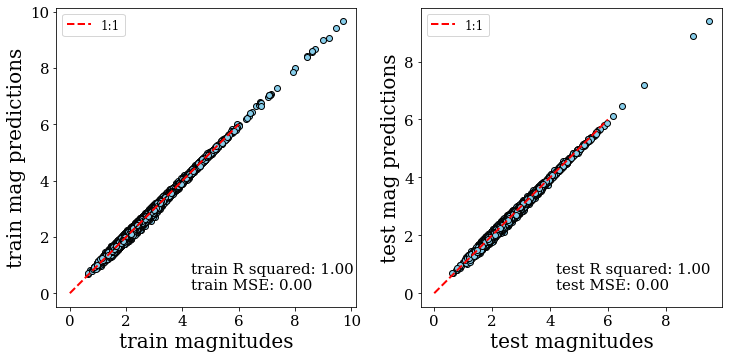

In [57]:
# set up figure
text_locs = (0.45, 0.1)
fig, ax = plt.subplots(1, 2, figsize=(12, 5.5))
# add plot elements
ax[0].plot(y_train, y_hat_train, 'o', color='skyblue', mec='k')
ax[0].plot([1.5, 5], [1.5, 5], color='k')
ax[0].text(
    *text_locs, f"train R squared: {train_score:.2f}\ntrain MSE: {mse_train:.2f}", 
    horizontalalignment='left', verticalalignment='center', transform=ax[0].transAxes
    )
ax[0].set(xlabel='train magnitudes', ylabel='train mag predictions')
ax[1].plot(y_test, y_hat_test, 'o', color='skyblue', mec='k')
ax[1].text(
    *text_locs, f"test R squared: {test_score:.2f}\ntest MSE: {mse_test:.2f}", 
    horizontalalignment='left', verticalalignment='center', transform=ax[1].transAxes
    )
ax[1].set(xlabel='test magnitudes', ylabel='test mag predictions')
# universal subplot features
for a in ax:
    a.set_aspect('equal', 'box')
    a.plot([0, 6], [0, 6], '--', color='r', lw=2, label="1:1")
    a.legend()
fig.savefig("../assets/mag-regress.jpeg", bbox_inches='tight')

## 2.2 - Evaluating the event Mw predictions from the linear regression model
The event magnitude is defined as the average of all station magnitude estimates. We will evaluate the quality of the model predictions for production by its ability to predict a single event magnitude.

In [58]:
# predict station magnitudes for all events 
mag_eval = data.data.copy(deep=True)
X_eval = mag_eval[train_on]
mag_eval["lin-reg-station-Mw"] = mag_regress.predict(X_eval)
# predict event magnitudes
ev_groups = mag_eval.groupby("otime") # group by origin time
# get the mean Mw for each group.
mean_mw = ev_groups[["lin-reg-station-Mw", "holt-19-station-Sg-Mw"]].mean()
mw_resids = mean_mw["holt-19-station-Sg-Mw"] - mean_mw["lin-reg-station-Mw"]

## Take a look at the residuals between the 'expert' label and linear regression label. 

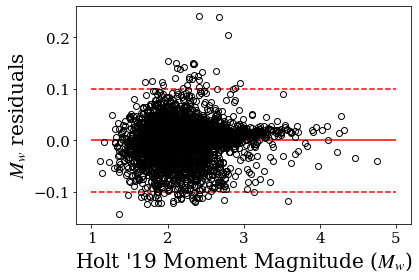

In [64]:
fig, ax = plt.subplots(1, 1)
ax.plot(median_mw["holt-19-station-Sg-Mw"].values, mw_resids.values, 'ko', mfc='none')
ax.hlines(0, 1, 5, color='red')
for n in [-0.1, 0.1]:
    ax.hlines(n, 1, 5, color='red', linestyles='dashed')
_ = ax.set(
    xlabel=r"Holt '19 Moment Magnitude ($M_w$)",
    ylabel=r"$M_w$ residuals"
    )

In [62]:
bad_evs = mw_resids[np.abs(mw_resids) > 0.1].index
mag_eval[mag_eval['otime'].isin(bad_evs)]

otime station   dep        repi        rhyp  \
79     2012-10-07 23:14:03.380000+00:00     KNB  3.65   21.289340   21.553636   
80     2012-10-07 23:14:03.380000+00:00    LCMT  3.65   51.125168   51.216721   
81     2012-10-07 23:14:03.380000+00:00    MTPU  3.65  105.665852  105.773101   
82     2012-10-07 23:14:03.380000+00:00    PKCU  3.65   45.567575   45.787664   
83     2012-10-07 23:14:03.380000+00:00    SZCU  3.65   56.215152   56.335213   
...                                 ...     ...   ...         ...         ...   
31808  2018-04-01 22:41:56.020000+00:00     MPU  3.79  142.353633  142.401683   
31809  2018-04-01 22:41:56.020000+00:00    PNSU  3.79  138.055538  138.129937   
31810  2018-04-01 22:41:56.020000+00:00     SRU  3.79  195.387395  195.420447   
31811  2018-04-01 22:41:56.020000+00:00    AHID  3.79  219.206352  219.238426   
31812  2018-04-01 22:41:56.020000+00:00    HWUT  3.79  128.998243  129.049026   

          llpsp         fc     Mw  log-rhyp    log-fc  holt-19-dist-corr  \
79    -7.809676   5.582579  1.775  1.333521  0.746835           1.200168   
80    -8.149982  13.685024  1.775  1.709412  1.136246           1.665296   
81    -8.695018   3.774317  1.775  2.024375  0.576838           2.168966   
82    -7.660413   4.547169  1.775  1.660748  0.657741           1.540231   
83    -7.532592   9.491147  1.775  1.750780  0.977319           1.771612   
...         ...        ...    ...       ...       ...                ...   
31808 -8.542513  13.468543  2.007  2.153515  1.129321           2.247761   
31809 -8.095076  23.191552  2.007  2.140288  1.365330           2.227391   
31810 -7.739217   4.103679  2.007  2.290970  0.613173           2.459442   
31811 -7.650681   2.817695  2.007  2.340917  0.449894           2.536360   
31812 -8.186326   3.258405  2.007  2.110755  0.513005           2.206973   

       holt-19-source-llpsp  source-vel-Sg  source-density  \
79                -6.609507    3421.781178     2658.249427   
80                -6.484686    3421.781178     2658.249427   
81                -6.526052    3421.781178     2658.249427   
82                -6.120182    3421.781178     2658.249427   
83                -5.760980    3421.781178     2658.249427   
...                     ...            ...             ...   
31808             -6.294752    3431.899673     2662.197381   
31809             -5.867685    3431.899673     2662.197381   
31810             -5.279776    3431.899673     2662.197381   
31811             -5.114321    3431.899673     2662.197381   
31812             -5.979353    3431.899673     2662.197381   

       holt-19-station-Sg-M0  holt-19-station-Sg-Mw  lin-reg-station-Mw  
79              2.610265e+11               1.577823            1.666491  
80              3.479414e+11               1.661037            1.780855  
81              3.163295e+11               1.633460            1.690149  
82              8.053974e+11               1.904040            2.057535  
83              1.841670e+12               2.143508            2.228094  
...                      ...                    ...                 ...  
31808           5.444162e+11               1.790654            1.915555  
31809           1.455455e+12               2.075366            2.206148  
31810           5.635176e+12               2.467305            2.567752  
31811           8.248259e+12               2.577608            2.669204  
31812           1.125461e+12               2.000920            2.106383  

[641 rows x 17 columns]